# Readability Exercise

Welcome! Below you will implement two metrics for evaluating the readability of documents:

1. Flesch–Kincaid readability Grade Index 
2. Gunning Fog Index

The solutions are in [readability_solutions.py](./readability_solutions.py). You can also click the jupyter icon to see all the files in the folder.

To load all the functions in the solutions, simply include `from solutions import *`

## 0. Initialization

Let's read-in our text files. We have three different texts files to play with: 

1. `physics.txt`: taken from a technical wikipedia article about a theoretical physics idea called [Supersymmetry](https://en.wikipedia.org/wiki/Supersymmetry)

2. `APPL_10k_2017.txt`: the 2017 10-K Item IA for APPLE INC, taken from the EDGAR website

3. `alice.txt`: Excerpts from "Alice in Wonderland", the novel is in the public domain and freely available

In [1]:
# download some excerpts from 10-K files

from download10k import get_files

CIK = {'ebay': '0001065088', 'apple':'0000320193', 'sears': '0001310067'}
get_files(CIK['ebay'], 'EBAY')
get_files(CIK['apple'], 'AAPL')
get_files(CIK['sears'], 'SHLDQ')

# get a list of all 10-ks in our directory
files=! ls *10k*.txt
print("10-k files: ",files)
files = [open(f,"r").read() for f in files]

downloading 10-Ks item 1A for CIK = 0001065088 ...
downloading 10-Ks item 1A for CIK = 0000320193 ...
downloading 10-Ks item 1A for CIK = 0001310067 ...
10-k files:  ['AAPL_10k_2016.txt', 'AAPL_10k_2017.txt', 'SHLDQ_10k_2014.txt', 'SHLDQ_10k_2015.txt', 'SHLDQ_10k_2016.txt', 'SHLDQ_10k_2017.txt']


In [5]:
# sentences separated by ; are better viewed as multiple sentences
# join combines all the newlines in the file

f = open("physics.txt", "r")
text_phy=''.join(f).replace(';','.')

f = open("alice.txt", "r")
text_alice=''.join(f).replace(';','.')

f = open("AAPL_10k_2017.txt", "r")
text_10k=''.join(f).replace(';','.')

In [6]:
# check out some of the texts
print(text_10k[:500]+"...\n")
print(text_phy[:500]+"...\n")
print(text_alice[:500]+"...\n")

Global economic conditions could materially
adversely affect the Company.  The Companys operations and performance depend significantly on worldwide economic
conditions. Uncertainty about global economic conditions poses a risk as consumers and businesses postpone spending in response to tighter credit, unemployment, negative financial news and/or declines in income or asset values. For example, the
continuing sovereign debt crisis, financial market volatility, and other factors in Europe have ...

In particle physics, supersymmetry (SUSY) is a principle that proposes a relationship between two basic classes of elementary particles: bosons, which have an integer-valued spin, and fermions, which have a half-integer spin. A type of spacetime symmetry, supersymmetry is a possible candidate for undiscovered particle physics, and seen as an elegant solution to many current problems in particle physics if confirmed correct, which could resolve various areas where current theories are believ

## 1. Pre-processing
Here, we need to define functions that can split our texts into sentences, and split our sentences into words

In [9]:
# tokenize and clean the text
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import Counter
from nltk.corpus import stopwords

from nltk import word_tokenize
from syllable_count import syllable_count


nltk.download('wordnet')

sno = SnowballStemmer('english')
wnl = WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer

# tokenizer that selects out non letter and non symbol (i.e. all alphabets)
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')


def word_tokenize(sent):
    return [ w for w in word_tokenizer.tokenize(sent) if w.isalpha() ]

# for the sentence tokenizer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# you can tokenize sentences by calling
# sent_tokenize(document)

# and tokenize words by calling
# word_tokenize(sentence)

# syllable_count counts the number of syllables in a word
# it's included in syllable_count.py

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now implement three functions

1. `sentence_count`: a simple function that returns the number of sentences in a document

2. `word_count`: a simple function that returns the number of words in a sentence

3. `hard_word_count`: a simple function that returns the number of words with more than 3 syllables, while removing suffixes like "-ed", and "-ing". This can be done by lemmatizing the word, i.e. `wnl.lemmatize(word, pos='v')`

the function `word_tokenize(sentence)` will be useful here

In [10]:
def sentence_count(text):
    return len(sent_tokenizer.tokenize(text))

def word_count(sent):
    return len([ w for w in word_tokenize(sent)])

def hard_word_count(sent):
    return len([ w for w in word_tokenize(sent) if syllable_count(wnl.lemmatize(w, pos='v'))>=3 ])

## 2. Readability Grade-Levels

Here, you will implement the two readability indices (grade levels). They are defined by

\begin{align}
\textrm{Flesch–Kincaid Grade} 
= 0.39 \left(
\frac{\textrm{Number of words}}{\textrm{Number of sentences}}
\right) \\
+11.8
\left(
\frac{\textrm{Number of syllables}}{\textrm{Number of words}}
\right)
-15.59
\end{align}

and

\begin{align}
\textrm{Gunning-Fog Grade} 
=\; &0.4 \bigg[ 
\left(
\frac{\textrm{Number of words}}{\textrm{Number of sentences}}
\right) 
+100
\left(
\frac{\textrm{Number of hard words}}{\textrm{Number of words}}
\right)
\bigg]
\end{align}

To count syllables, we've added a syllable_count function you can access via 

```
from syllable_count import syllable_count
syllable_count("syllable")
```

Below, implement the function `flesch_index` and `fog_index` that computes the readability grade level for a given text.

In [11]:
import numpy as np

def flesch_index(text):
    sentences = sent_tokenize(text)
    total_sentences = len(sentences)
    total_words = np.sum([ word_count(s) for s in sentences ])
    total_syllables = np.sum([ np.sum([ syllable_count(w) for w in word_tokenize(s) ]) \
                              for s in sentences ])
    return 0.39*(total_words/total_sentences) + 11.8*(total_syllables/total_words) - 15.59

def fog_index(text):
    sentences = sent_tokenize(text)
    total_sentences = len(sentences)
    total_words = np.sum([ word_count(s) for s in sentences ])
    total_hard_words = np.sum([ hard_word_count(s) for s in sentences ])
    return 0.4*((total_words/total_sentences) + 100.0*(total_hard_words/total_words))

## 3 Results

Now that you've coded up the exercises, compute the grade levels for each of the texts given.


In [12]:
# to test the solutions
# uncommon next line
# from readability_solutions import *

print(flesch_index(text_alice),fog_index(text_alice))
print(flesch_index(text_phy),fog_index(text_phy))
print(flesch_index(text_10k),fog_index(text_10k))

7.78094652406 9.73654188948
16.3171712123 19.3225332001
18.1336596757 21.4219541786


You should expect a grade level around 7-10 for `alice.txt`, and around 16-19 for `physics.txt`, and 18+ for financial documents! 

It turns out 10-Ks are really *hard* to read legal documents!
Now, let's compute the readability for all the 10-Ks we have

In [13]:
filelist_10k=!ls *10k*txt


flesch = []
fog = []

for file in filelist_10k:
    with open(file, 'r') as f:
        text=''.join(f).replace(';','.')
        flesch.append(flesch_index(text))
        fog.append(fog_index(text))
        print(file, flesch[-1],fog[-1])

AAPL_10k_2016.txt 19.0414157978 22.4242197611
AAPL_10k_2017.txt 18.1336596757 21.4219541786
SHLDQ_10k_2014.txt 16.6263736264 19.6307692308
SHLDQ_10k_2015.txt 16.4470259768 19.2046843394
SHLDQ_10k_2016.txt 16.8126305116 19.2154420317
SHLDQ_10k_2017.txt 17.755571973 20.6452057848


**Superficially, and according to our readability metrics, reading 10-Ks is harder than reading articles on theoretical physics!**

# Bonus exercise:
How are the two readability grade-levels correlated? Compute the covariance matrix of the two readability indices we have on all the 10K documents, and make a scatter plot of Flesch index vs Fog index. Also perform a least-squared fit to the result and plot it as well.

(change bottom cell to code and remove html tags for solution)

In [32]:
flesch = np.array(flesch)
fog = np.array(fog)

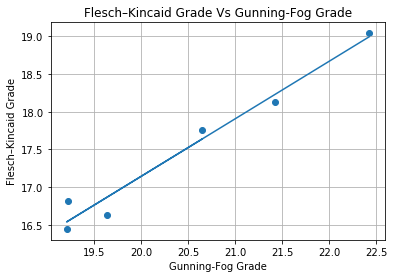

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.scatter(fog, flesch)
m, b = np.polyfit(fog, flesch, 1)
plt.plot(fog, m*fog + b)
plt.title('Flesch–Kincaid Grade Vs Gunning-Fog Grade')
plt.xlabel('Gunning-Fog Grade')
plt.ylabel('Flesch–Kincaid Grade')
plt.grid()
plt.show()

There is a correlation between both coefficients

<font color="white">

#solution
cov = np.cov(flesch,fog)
print(cov)

%matplotlib inline

plt.figure(figsize=(6,5))
plt.scatter(flesch,fog) 

slope, intercept, r_value, p_value, std_err = linregress(flesch, fog)

x=np.linspace(16.5,19,101)
y=slope*x+intercept
plt.plot(x,y)

plt.xlabel("Flesch Index")
plt.ylabel("Fog Index")

</font>